In [1]:
import sys
import os
os.chdir("/athena/marchionnilab/scratch/lab_data/Mohamed/pca_TME")
#sys.setrecursionlimit(22000)
from pathlib import Path
import scanpy as sc
from matplotlib.pyplot import ion
import pandas as pd
import scipy.sparse as sp
import loompy as lp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.plotting import plot_binarization, plot_rss
from pyscenic.rss import regulon_specificity_scores
from pyscenic.transform import df2regulons
from pyscenic.utils import load_motifs
from matplotlib.pyplot import gcf
sc.settings.figdir = ''

In [2]:
sc._settings.ScanpyConfig(plot_suffix = '', n_jobs = 20, max_memory = 100)
sc.set_figure_params(dpi_save = 300)

############

# Regulons

In [3]:
adata_mouse = sc.read_h5ad('outs/h5ads/fapcm_fibroblasts_v6_clean_regulons_5.h5ad', chunk_size=100000)

In [4]:
adata_mouse.obs['cluster'] = adata_mouse.obs['cluster'].astype('str')
# filter the na
adata_mouse = adata_mouse[adata_mouse.obs['cluster'] != 'nan', :]

In [5]:
# load the scenic output
auc_mtx = pd.read_csv('scenic/results/fibroblasts.auc.csv', index_col=0)
bin_mtx = pd.read_csv('scenic/results/fibroblasts.bin.csv', index_col=0)
thresholds = pd.read_csv('scenic/results/fibroblasts.thresholds.csv', index_col=0).threshold

2022-05-07 10:17:13.943693: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-05-07 10:17:13.943728: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


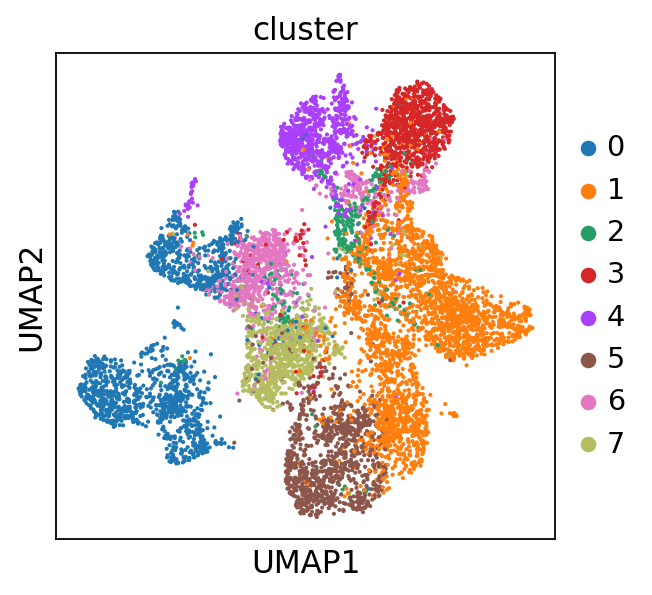

In [6]:
# recompute the neighbors
sc.pp.pca(adata_mouse)
sc.pp.neighbors(adata_mouse)
sc.tl.umap(adata_mouse)
sc.pl.umap(adata_mouse, color='cluster', save = 'mouse_umap.png')

In [7]:
# Arrange the cell annotation dataframe by the clusters
adata_mouse.obs.sort_values(by = ['cluster'], inplace=True)

# Re-arrange the cells in auc_mtx to match those in cellAnnotation
auc_mtx['CellID'] = auc_mtx.index
cell_index = pd.DataFrame(adata_mouse.obs_names)
cell_index = cell_index.rename(columns = {0:'CellID'})
auc_mtx_ord = cell_index.merge(auc_mtx, on = "CellID")
auc_mtx_ord.index = auc_mtx_ord['CellID']
del auc_mtx_ord['CellID']

In [8]:
# calc regulon specificity score
rss_cellType = regulon_specificity_scores( auc_mtx_ord, adata_mouse.obs['cluster'] )
rss_cellType

# Select the top 5 regulons from each cell type
cats = sorted(list(set(adata_mouse.obs['cluster'])))
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))


In [9]:
# Generate a Z-score for each regulon to enable comparison between regulons
auc_mtx_Z = pd.DataFrame( index=auc_mtx_ord.index )
for col in list(auc_mtx_ord.columns):
    auc_mtx_Z[ col ] = ( auc_mtx_ord[col] - auc_mtx_ord[col].mean()) / auc_mtx_ord[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)
# Transpose
auc_mtx_Z_transposed = auc_mtx_Z.transpose()

In [10]:
# Filter to the top 10 regulons per cluster
auc_mtx_Z_top10 = auc_mtx_Z[topreg]
# Transpose
auc_mtx_Z_top10_transposed = auc_mtx_Z_top10.transpose()

In [11]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

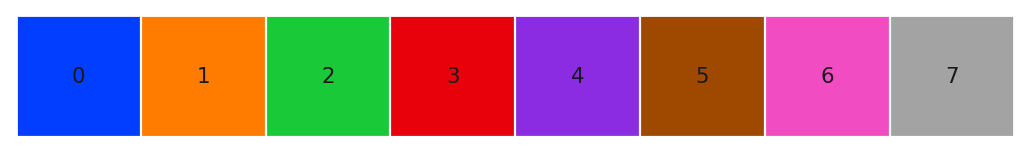

In [12]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in adata_mouse.obs['cluster'] ]
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("scenic/figures/cluster_colors.svg", dpi=600, bbox_inches = "tight")

/pbtech_mounts/homes064/mao4005/.conda/envs/pathml/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


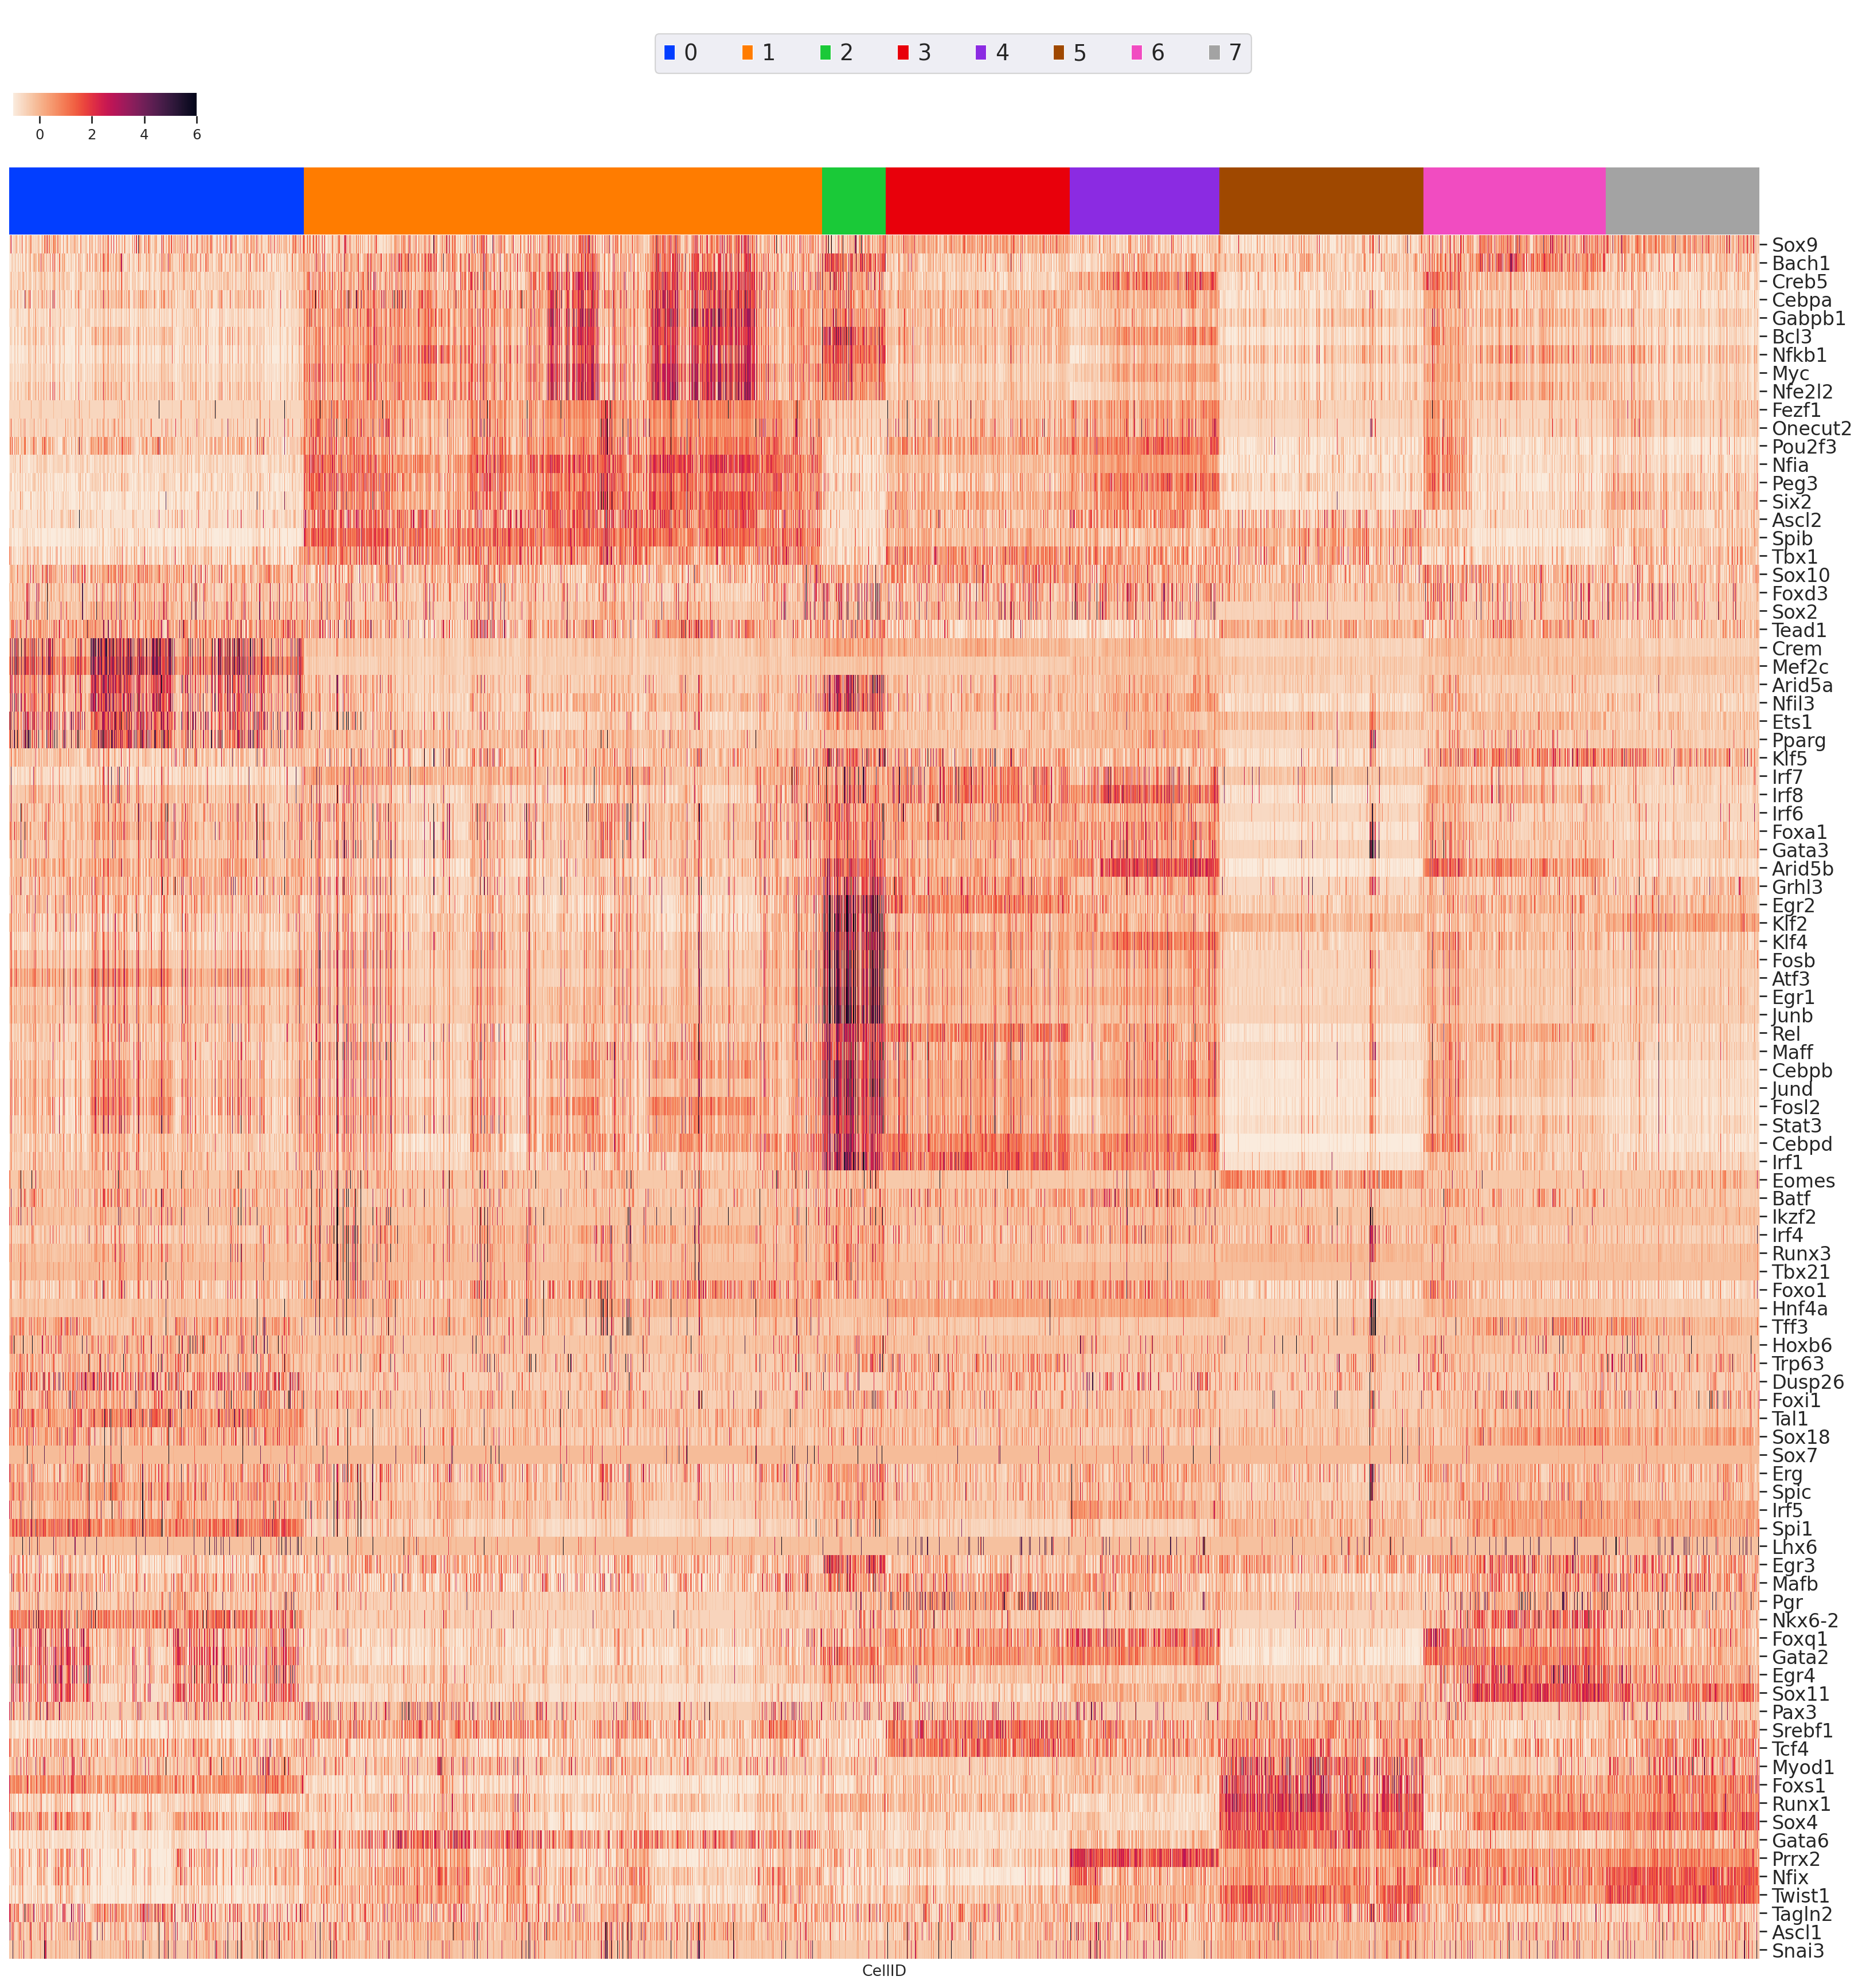

In [13]:
##################################################
# heatmap of all regulons in all clusters
sns.set(font_scale=1)
g = sns.clustermap(auc_mtx_Z_transposed, annot=False,  square=False,  linecolor='gray',
    xticklabels=False, yticklabels=True, vmin=-1, vmax=6, col_colors=colormap,
    cmap="rocket_r", figsize=(25,25), col_cluster = False,
    cbar_pos=(.2, .82, .08, .01),
    cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25, orientation = 'horizontal')
)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 15, fontweight = 'medium')
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(True)

# for the legend
for cluster in cats:
    g.ax_col_dendrogram.bar(0, 0, color=colorsd[cluster],
                            label=cluster, linewidth=0.5)
g.ax_col_dendrogram.legend(loc="center", ncol=9, bbox_transform=gcf().transFigure, fontsize = 'x-large')
col = g.ax_col_dendrogram.get_position()
g.ax_col_dendrogram.set_position([col.x0+0.03, col.y0+0.03, col.width*1.0, col.height*0.2])

#plt.tight_layout()
plt.savefig("scenic/figures/scenic_mouse.pdf", dpi=600, bbox_inches = "tight")

/pbtech_mounts/homes064/mao4005/.conda/envs/pathml/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


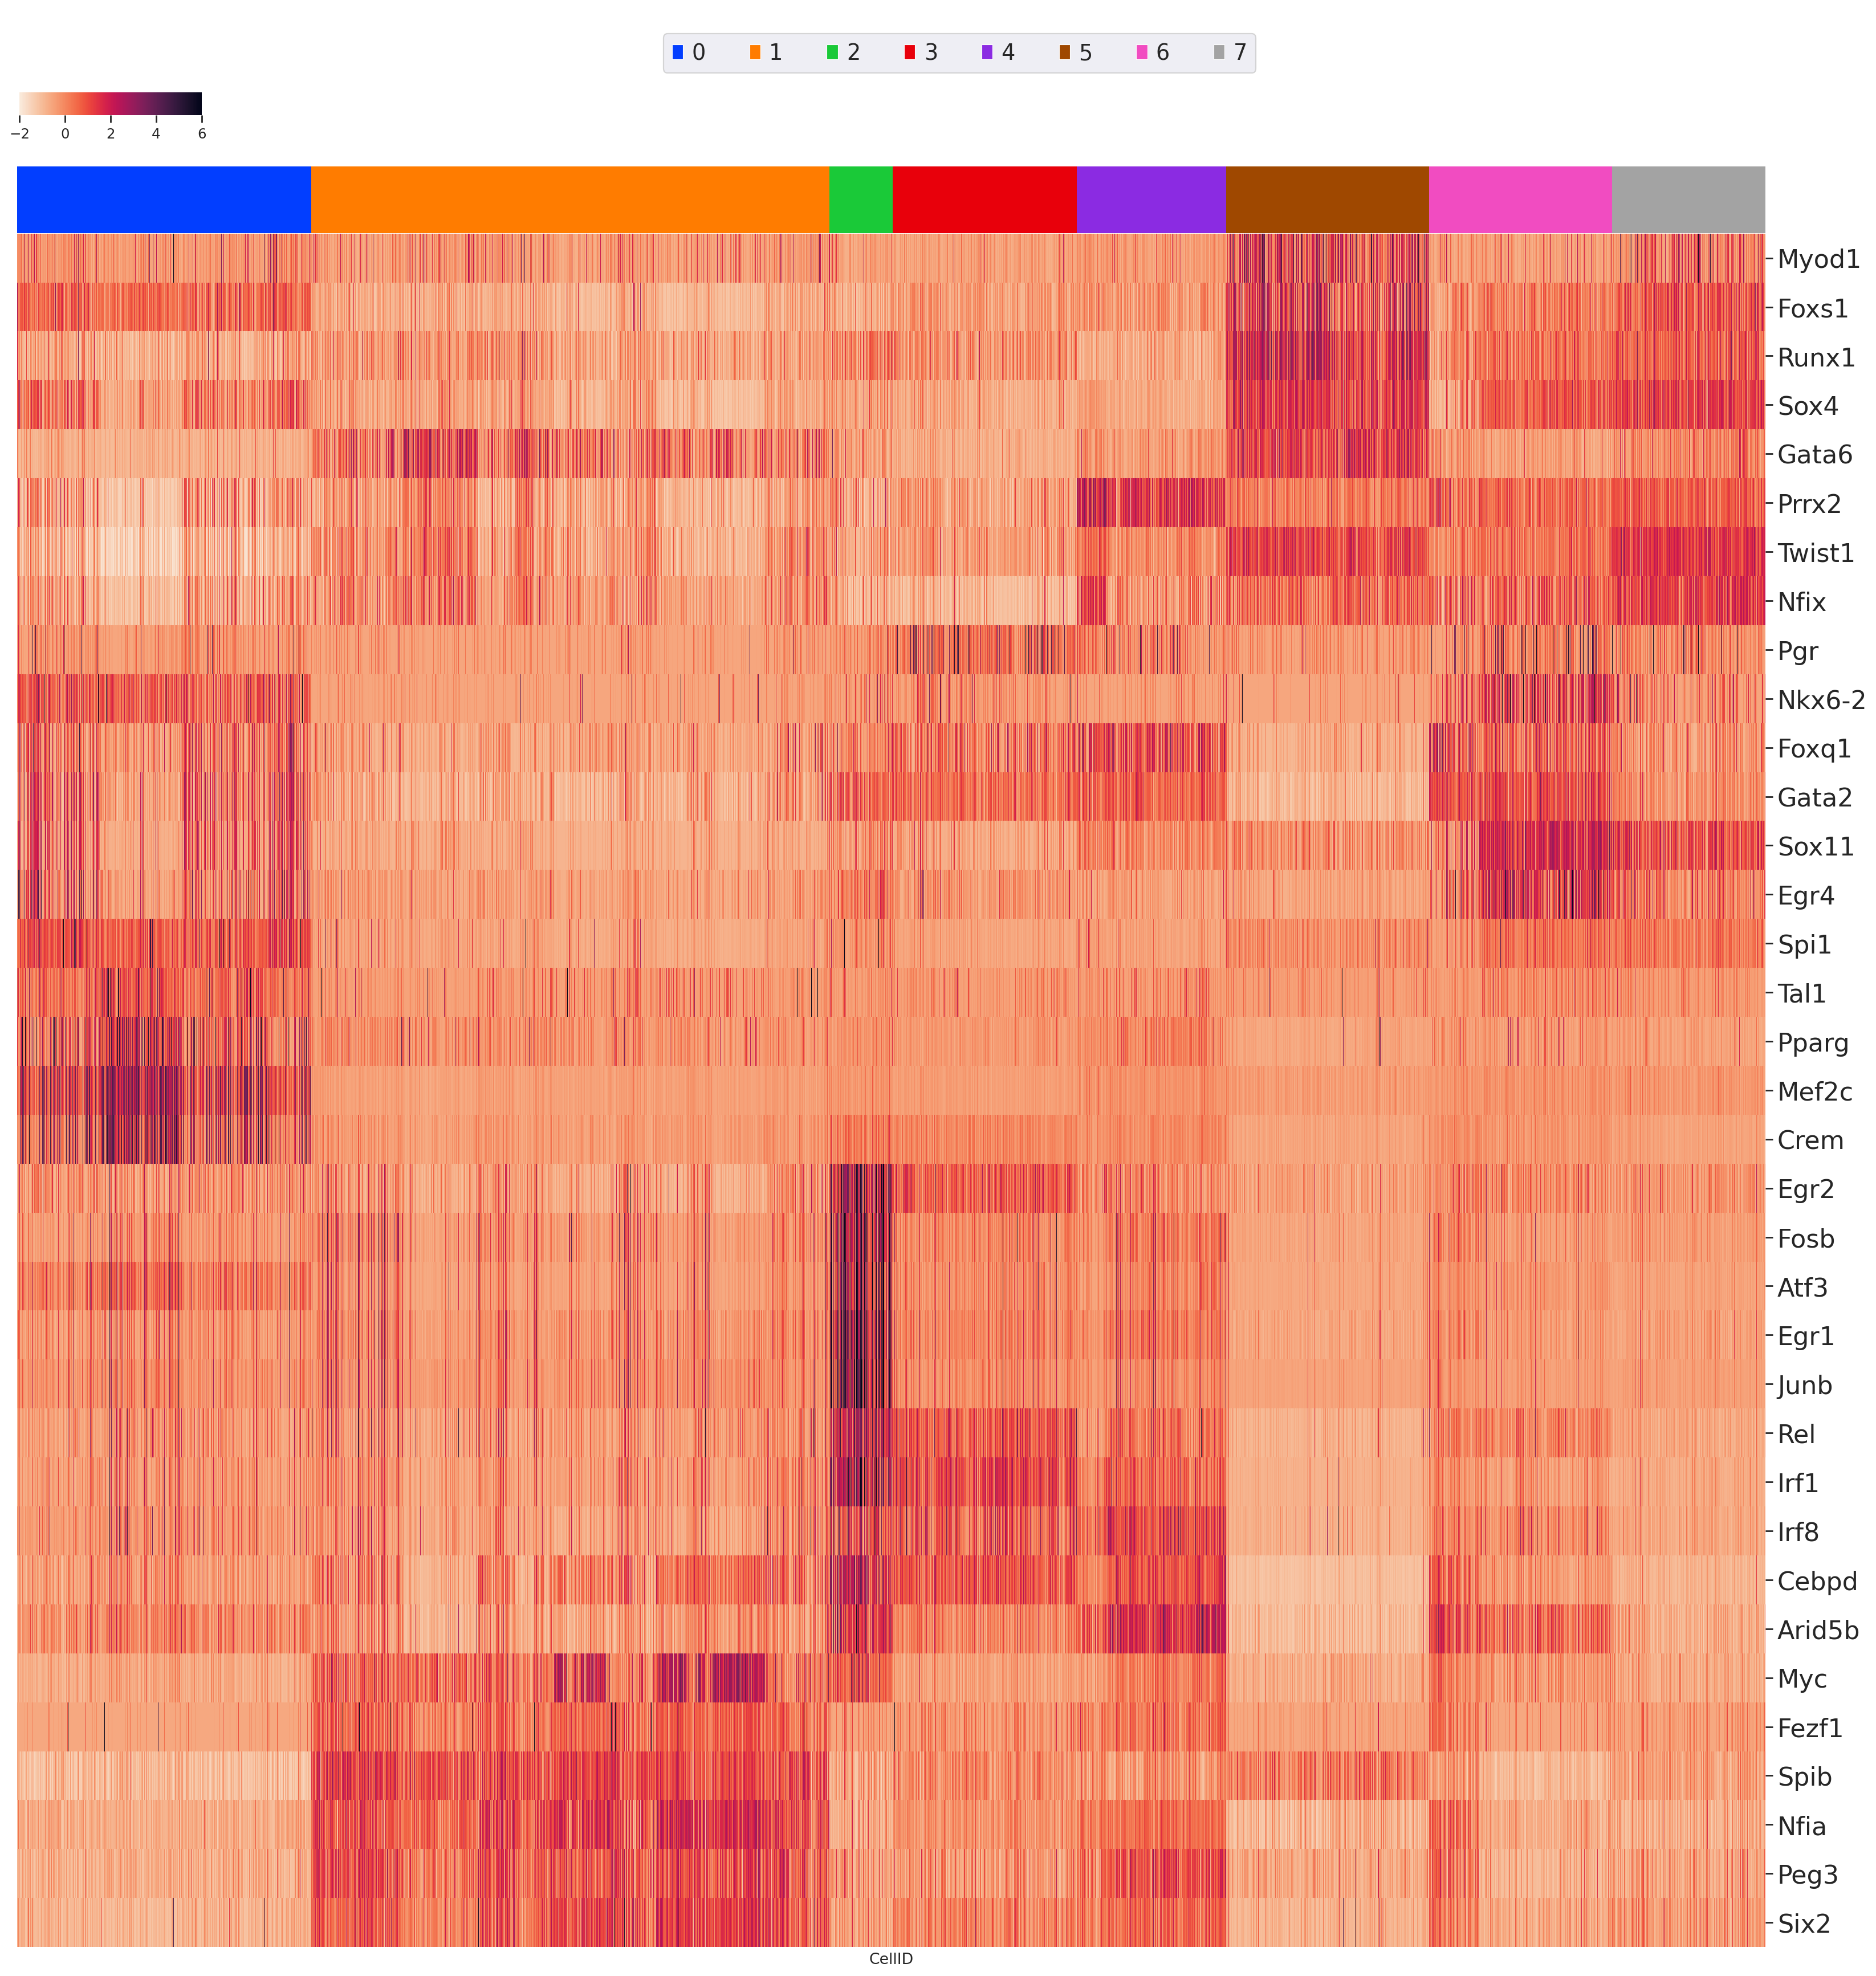

In [14]:
##################################################
# heatmap of top 10 regulons in all clusters
sns.set(font_scale=1)
g = sns.clustermap(auc_mtx_Z_top10_transposed, annot=False,  square=False,  linecolor='gray',
    xticklabels=False, yticklabels=True, vmin=-2, vmax=6, col_colors=colormap,
    cmap="rocket_r", figsize=(25,25), col_cluster = False,
    cbar_pos=(.2, .82, .08, .01),
    cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25, orientation = 'horizontal')
)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 20, fontweight = 'medium')
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(True)

# for the legend
for cluster in cats:
    g.ax_col_dendrogram.bar(0, 0, color=colorsd[cluster],
                            label=cluster, linewidth=0.5)
g.ax_col_dendrogram.legend(loc="center", ncol=9, bbox_transform=gcf().transFigure, fontsize = 'x-large')
col = g.ax_col_dendrogram.get_position()
g.ax_col_dendrogram.set_position([col.x0+0.03, col.y0+0.03, col.width*1.0, col.height*0.2])

#plt.tight_layout()
plt.savefig("scenic/figures/scenic_mouse_top10.pdf", dpi=600, bbox_inches = "tight")

# binary heatmap

In [15]:
# Re-arrange the cells in bin_mtx to match those in cellAnnotation
bin_mtx['CellID'] = bin_mtx.index
cell_index = pd.DataFrame(adata_mouse.obs_names)
cell_index = cell_index.rename(columns = {0:'CellID'})
bin_mtx_ord = cell_index.merge(bin_mtx, on = "CellID")
bin_mtx_ord.index = bin_mtx_ord['CellID']
del bin_mtx_ord['CellID']

In [16]:
# Filter to the top 10 regulons per cluster
bin_mtx_top10 = bin_mtx_ord[topreg]
# Transpose
bin_mtx_top10_transposed = bin_mtx_top10.transpose()

In [17]:
adata_mouse.obs.cluster = adata_mouse.obs.cluster.astype('category')
adata_mouse.obs.cluster.value_counts()

1    2541
0    1442
5     997
3     903
6     895
7     753
4     733
2     310
Name: cluster, dtype: int64

In [29]:
# binary heatmap for all regulons in all clusters
N_COLORS = len(adata_mouse.obs.cluster.dtype.categories)
COLORS = [color['color'] for color in mpl.rcParams["axes.prop_cycle"]]

cell_type_color_lut = dict(zip(adata_mouse.obs.cluster.dtype.categories, COLORS))
cell_type_color_lut = dict(zip(adata_mouse.obs.cluster.dtype.categories, adata_mouse.uns['cluster_colors']))
#cell_id2cell_type_lut = anndata.var.set_index('cell_id').cell_type.to_dict()
bw_palette = sns.xkcd_palette(["white", "black"])

sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(bin_mtx_ord.T,
                col_colors=bin_mtx_ord.index.map(adata_mouse.obs['cluster'].to_dict()).map(cell_type_color_lut),
                yticklabels=True, col_cluster = False,
                cmap=bw_palette, figsize=(50,75))

# for the legend
for cluster in cats:
    g.ax_col_dendrogram.bar(0, 0, color=colorsd[cluster],
                            label=cluster, linewidth=0.5)
g.ax_col_dendrogram.legend(loc="center", ncol=8, bbox_transform=gcf().transFigure, fontsize = 60)
col = g.ax_col_dendrogram.get_position()
g.ax_col_dendrogram.set_position([col.x0+0.02, col.y0+0.02, col.width*1.0, col.height*0.2])

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 30, fontweight = 'medium')
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Cells')
g.ax_heatmap.set_ylabel('Regulons')
g.ax_col_colors.set_yticks([0.5])
g.ax_col_colors.set_yticklabels(['Cell Type'])
g.cax.set_visible(False)
g.ax_col_dendrogram.set_visible(True)
g.ax_row_dendrogram.set_visible(False)
plt.tight_layout()
g.fig.savefig(os.path.join('scenic/figures', 'scenic_mouse_binary.png'), dpi=200, format='png')

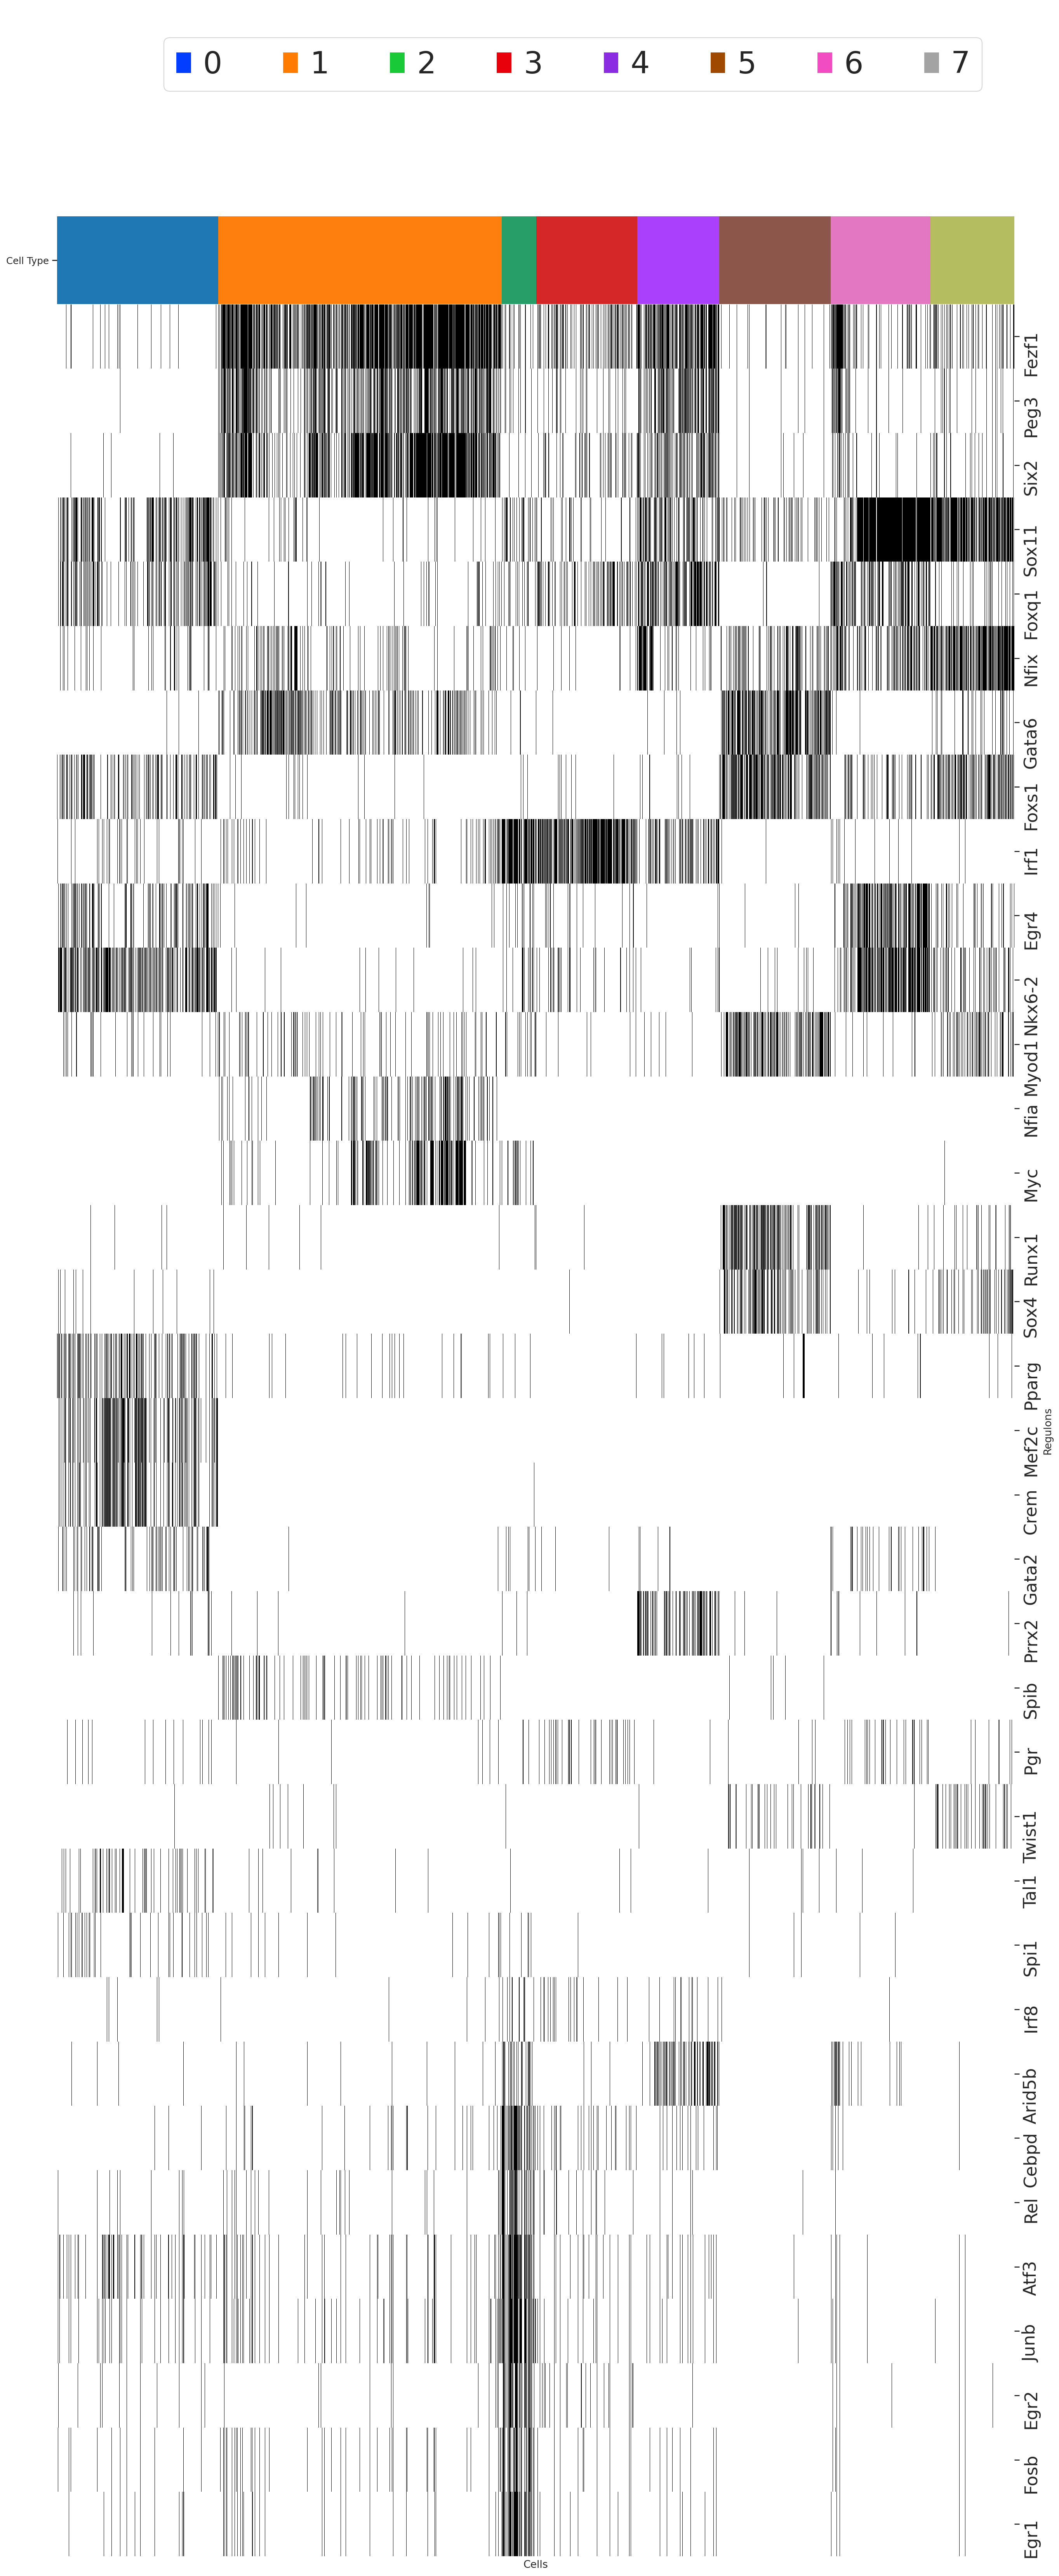

In [19]:
# binary heatmap for top 10 regulons in all clusters
N_COLORS = len(adata_mouse.obs.cluster.dtype.categories)
COLORS = [color['color'] for color in mpl.rcParams["axes.prop_cycle"]]

cell_type_color_lut = dict(zip(adata_mouse.obs.cluster.dtype.categories, COLORS))
cell_type_color_lut = dict(zip(adata_mouse.obs.cluster.dtype.categories, adata_mouse.uns['cluster_colors']))
#cell_id2cell_type_lut = anndata.var.set_index('cell_id').cell_type.to_dict()
bw_palette = sns.xkcd_palette(["white", "black"])

sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(bin_mtx_top10.T,
                col_colors=bin_mtx_ord.index.map(adata_mouse.obs['cluster'].to_dict()).map(cell_type_color_lut),
                yticklabels=True, col_cluster = False,
                cmap=bw_palette, figsize=(20,50))

# for the legend
for cluster in cats:
    g.ax_col_dendrogram.bar(0, 0, color=colorsd[cluster],
                            label=cluster, linewidth=0.5)
g.ax_col_dendrogram.legend(loc="center", ncol=8, bbox_transform=gcf().transFigure, fontsize = 30)
col = g.ax_col_dendrogram.get_position()
g.ax_col_dendrogram.set_position([col.x0+0.03, col.y0+0.03, col.width*1.0, col.height*0.2])


g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 20, fontweight = 'medium')
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Cells')
g.ax_heatmap.set_ylabel('Regulons')
g.ax_col_colors.set_yticks([0.5])
g.ax_col_colors.set_yticklabels(['Cell Type'])
g.cax.set_visible(False)
g.ax_col_dendrogram.set_visible(True)
g.ax_row_dendrogram.set_visible(False)
g.fig.savefig(os.path.join('scenic/figures', 'scenic_mouse_binary_top10.png'), dpi=200, format='png')

In [23]:
bin_mtx_clustered = bin_mtx_ord.T.copy()
# bin_mtx_clustered.rename(columns=df_annotations.set_index('cell_id')['cell_type'].to_dict(), inplace=True)
bin_mtx_clustered.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind].to_excel(os.path.join('human/scenic/results', 'bindata.xlsx'))
g.fig.savefig(os.path.join('human/scenic/figures', 'clustermap_binary2.png'), dpi=200, format='png')


AttributeError: 'NoneType' object has no attribute 'reordered_ind'